In [ ]:
import os
import pandas as pd

# Data path
labels_path = r'C:\Users\PC\OneDrive\Dokumen\python_programming\ts_TH4\Data\139\labels.txt'
trajectory_folder = r'C:\Users\PC\OneDrive\Dokumen\python_programming\ts_TH4\Data\139\Trajectory'

# Đọc labels.txt
def read_labels(label_file):
    df = pd.read_csv(label_file, sep='\t')
    df['start_time'] = pd.to_datetime(df['Start Time'])
    df['end_time'] = pd.to_datetime(df['End Time'])
    df.rename(columns={'Transportation Mode': 'transport_mode'}, inplace=True)
    return df[['start_time', 'end_time', 'transport_mode']]


# Đọc file .plt
def read_plt_file(file_path):
    df = pd.read_csv(file_path, skiprows=6, header=None)
    df.columns = ['lat', 'lon', 'unused', 'alt', 'days', 'date', 'time']
    df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
    return df[['lat', 'lon', 'alt', 'datetime']]

# Gán nhãn
def assign_labels(gps_df, labels_df):
    gps_df['transport_mode'] = 'unknown'
    for _, row in labels_df.iterrows():
        mask = (gps_df['datetime'] >= row['start_time']) & (gps_df['datetime'] <= row['end_time'])
        gps_df.loc[mask, 'transport_mode'] = row['transport_mode']
    return gps_df

# Duyệt tất cả file trong thư mục Trajectory
def process_trajectory_files(trajectory_folder, labels_df):
    all_data = []

    for filename in os.listdir(trajectory_folder):
        if filename.endswith('.plt'):
            file_path = os.path.join(trajectory_folder, filename)
            gps_df = read_plt_file(file_path)
            gps_df = assign_labels(gps_df, labels_df)
            gps_df['file_name'] = filename
            all_data.append(gps_df)

    return pd.concat(all_data, ignore_index=True)

# Chạy pipeline
labels_df = read_labels(labels_path)
result_df = process_trajectory_files(trajectory_folder, labels_df)

print(result_df.head())
# result_df.to_csv('gps_with_labels.csv', index=False)


         lat         lon         alt            datetime transport_mode  \
0  39.975000  116.333517  328.083990 2007-09-03 07:15:54            bus   
1  39.974900  116.333800  328.083990 2007-09-03 07:18:16            bus   
2  39.974933  116.333683   45.931759 2007-09-03 07:18:58            bus   
3  39.901033  116.315367  137.795276 2007-09-03 08:21:04           walk   
4  39.900800  116.315117  321.522310 2007-09-03 08:21:13           walk   

            file_name  
0  20070903071554.plt  
1  20070903071554.plt  
2  20070903071554.plt  
3  20070903071554.plt  
4  20070903071554.plt  


In [2]:
result_df.head()

,lat,lon,alt,datetime,transport_mode,file_name
0,39.975000,116.333517,328.083990,2007-09-03 07:15:54,bus,20070903071554.plt
1,39.974900,116.333800,328.083990,2007-09-03 07:18:16,bus,20070903071554.plt
2,39.974933,116.333683,45.931759,2007-09-03 07:18:58,bus,20070903071554.plt
3,39.901033,116.315367,137.795276,2007-09-03 08:21:04,walk,20070903071554.plt
4,39.900800,116.315117,321.522310,2007-09-03 08:21:13,walk,20070903071554.plt


1. Chuyển đổi dữ liệu sang dạng time series đều đặn 15 phút
Ta sẽ tính tốc độ di chuyển giữa các điểm và sau đó nội suy để có tốc độ mỗi 15 phút.

In [3]:
import pandas as pd
import numpy as np
df = result_df
# Giả sử df đã được đọc như bạn nêu
df = df.sort_values('datetime')
df['datetime'] = pd.to_datetime(df['datetime'])

# Tính khoảng cách giữa các điểm GPS
from geopy.distance import geodesic

def compute_speed(row1, row2):
    dist = geodesic((row1['lat'], row1['lon']), (row2['lat'], row2['lon'])).meters
    time_diff = (row2['datetime'] - row1['datetime']).total_seconds()
    if time_diff == 0:
        return 0
    return dist / time_diff  # m/s

df['speed'] = 0.0
for i in range(1, len(df)):
    df.loc[df.index[i], 'speed'] = compute_speed(df.iloc[i-1], df.iloc[i])

# Đặt datetime làm index và resample lại mỗi 15 phút
df_ts = df.set_index('datetime')[['speed']].resample('15T').mean().interpolate()

print(df_ts.head())


                        speed
datetime                     
2007-09-03 07:15:00  0.146885
2007-09-03 07:30:00  0.558292
2007-09-03 07:45:00  0.969698
2007-09-03 08:00:00  1.381105
2007-09-03 08:15:00  1.792511


C:\Users\PC\AppData\Local\Temp\ipykernel_6148\3160582374.py:23: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_ts = df.set_index('datetime')[['speed']].resample('15T').mean().interpolate()


2. Phân tích phổ để tìm chu kỳ hoạt động

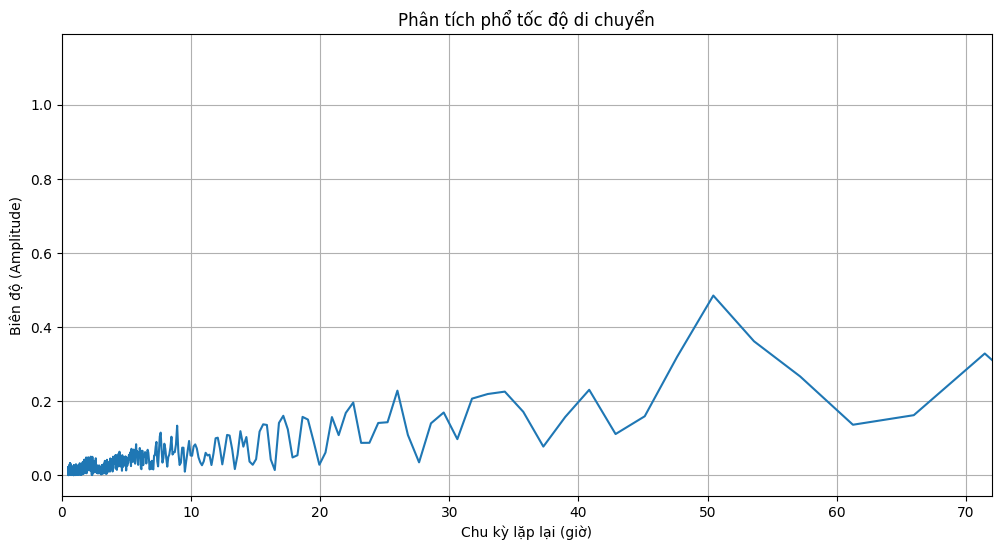

In [4]:
from scipy.fft import fft, fftfreq
import matplotlib.pyplot as plt

speed_signal = df_ts['speed'].values
N = len(speed_signal)
T = 15 * 60  # 15 phút = 900s

yf = fft(speed_signal)
xf = fftfreq(N, T)
yf = 2.0/N * np.abs(yf[1:N//2])
xf = xf[1:N//2]

# Chuyển sang đơn vị "chu kỳ (giờ)"
plt.figure(figsize=(12, 6))
plt.plot(1/xf/3600, yf)
plt.title('Phân tích phổ tốc độ di chuyển')
plt.xlabel('Chu kỳ lặp lại (giờ)')
plt.ylabel('Biên độ (Amplitude)')
plt.grid(True)
plt.xlim(0, 72)  # Xem trong khoảng 3 ngày
plt.show()


3. Nhận diện chu kỳ chính

In [5]:
from scipy.signal import find_peaks

peaks, properties = find_peaks(yf, height=np.max(yf)*0.2)  # Ngưỡng tùy chọn
for i in peaks:
    print(f"Chu kỳ: {1/xf[i]/3600:.2f} giờ - Độ mạnh: {yf[i]:.4f}")


Chu kỳ: 285.83 giờ - Độ mạnh: 0.8037
Chu kỳ: 171.50 giờ - Độ mạnh: 0.4642
Chu kỳ: 107.19 giờ - Độ mạnh: 0.2274
Chu kỳ: 71.46 giờ - Độ mạnh: 0.3287
Chu kỳ: 50.44 giờ - Độ mạnh: 0.4851
Chu kỳ: 40.83 giờ - Độ mạnh: 0.2308
Chu kỳ: 25.98 giờ - Độ mạnh: 0.2285


4. Trực quan hóa tần suất di chuyển theo giờ và ngày
Ta sẽ chuyển df_ts thành bảng tần suất dạng heatmap theo:

Trục x: giờ trong ngày (0 → 23)

Trục y: ngày trong tháng

Tạo bảng tần suất:

In [6]:
df_ts = df_ts.copy()
df_ts['hour'] = df_ts.index.hour
df_ts['day'] = df_ts.index.day

# Tính tốc độ trung bình theo ngày và giờ
heatmap_data = df_ts.pivot_table(index='day', columns='hour', values='speed', aggfunc='mean')


Vẽ Heatmap bằng Seaborn:

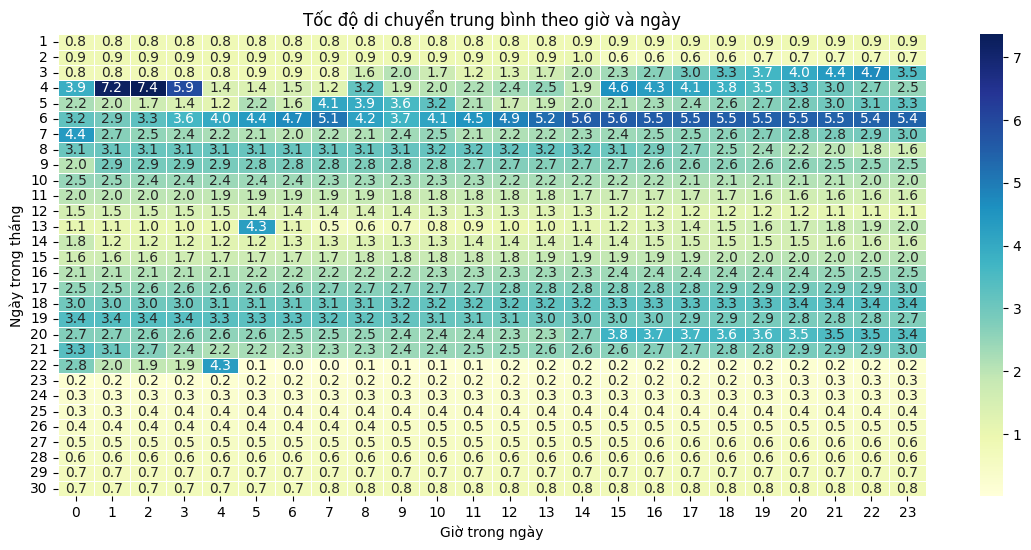

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, cmap='YlGnBu', linewidths=0.5, annot=True, fmt=".1f")
plt.title('Tốc độ di chuyển trung bình theo giờ và ngày')
plt.xlabel('Giờ trong ngày')
plt.ylabel('Ngày trong tháng')
plt.show()


5. Nhận diện thói quen cá nhân
Dựa trên:

Giờ cao điểm có tốc độ cao → khả năng dùng bus/train (đi học/làm).

Giờ thấp điểm gần bằng 0 → ở yên, ngủ hoặc làm việc cố định.

Nếu tốc độ cao về đêm → có thể là hành vi đặc biệt (làm đêm, đi chơi,...).



Tóm tắt pipeline đã thực hiện:
1. Gán nhãn từ labels.txt cho từng điểm GPS.

2. Tính tốc độ giữa các điểm.

3. Resample lại mỗi 15 phút (chuỗi đều).

4. Phân tích phổ (Fourier Transform) để tìm chu kỳ.

5. Heatmap thời gian để nhận diện thói quen.